# BART Exploratory Data Analysis

Coded by Joshua Chan in 10/2019. Updated 2/2020.

### Context

I grew up in the Bay Area, and I can say with some certainty that me and many of my colleagues have a shared distaste for BART. It can be confusing, unsafe, dirty, and loud--and we're hoping that one day BART will transform into a metro system capable of rivaling the efficient trains systems on the East Coast.

BART's weekend train schedule is unintuitive and baffling when first encountering it. Their train schedules are segmented based on the day of the week. It looks like this:
- **Weekdays**: All train stations are open. Trains run every 15 minutes. Most trains are 8-10 cars long.
- **Saturdays**: All train stations are open. Trains run every 20 minutes. Most trains are 4-6 cars long.
- **Sundays**: Some train lines are open. Trains run every 20 minutes. Most trains are 4-6 cars long.

It has confused me and my colleagues why Sundays seemed to be running on a significantly reduced schedule. Only half the train lines are available, even though it does not seem like Sunday ridership is significantly different from Sunday ridership. *In this notebook, I investigate whether or not it makes sense for BART to have disjointed train line schedules on Sundays compared to other days.*

### Outline

0. Setting Up, Data Cleaning
1. Preliminary EDA to contextualize the BART system
    - First Hypothesis: If we showcase the drop off in Sunday rides because of the transfers, we can justify having full train service for the entire week.
    - i.e. {Saturday w/only transfers - Sunday w/only transfers} - {Saturday w/no transfers - Sunday w/ no transfers}
    - The result ends up being...about 0, which indicates that people don't really care about the fact that you have to transfer? If people don't really care, then why maintain run a full track schedule over Saturday then?
    - What are some of the differences between riding on Sunday then Saturday aside from Train Schedule?
4. Experiment Part 2:
    - Second Hypothesis: If 

## 0. Setting Up

In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import datetime
import warnings
import re

sns.set()
sns.axes_style("darkgrid")
warnings.filterwarnings("ignore", category = FutureWarning)
sns.set_context('talk') # Makes the axes labels larger

In [14]:
# Add the relevant data sets
bart_11 = pd.read_csv('bart_2011.csv', header = None) # 2011 Bart Data
bart_12 = pd.read_csv('bart_2012.csv', header = None)
bart_13 = pd.read_csv('bart_2013.csv', header = None)
bart_14 = pd.read_csv('bart_2014.csv', header = None)
bart_15 = pd.read_csv('bart_2015.csv', header = None)
bart_16 = pd.read_csv('bart_2016.csv', header = None)
bart_17 = pd.read_csv('bart_2017.csv', header = None)
bart_18 = pd.read_csv('bart_2018.csv', header = None)
station = pd.read_csv('station_info.csv') # Information about what abbreviations are which stations

In [15]:
bart_18.head()

,0,1,2,3,4
0,2018-01-01,0,12TH,12TH,3
1,2018-01-01,0,12TH,16TH,1
2,2018-01-01,0,12TH,BAYF,1
3,2018-01-01,0,12TH,CAST,3
4,2018-01-01,0,12TH,CIVC,2


####  Cleaning the data

In [16]:
bart_districts = {
    "North Alameda": ['RICH', 'DELN', 'PLZA','NBRK','DBRK','ASHB','ROCK'],
    "East Alameda": ['CAST', 'WDUB', 'DUBL'],
    "Central Alameda": ["MCAR", '12TH', '19TH', 'WOAK', 'LAKE','FTVL','COLS', 'OAKL', 'SANL','BAYF'],
    "South Alameda": ['HAYW','SHAY','UCTY','FRMT', 'WARM', 'WSPR'],
    "West Contra Costa": ['ORIN', 'LAFY', 'WCRK', 'PHIL'],
    "East Contra Costa": ['ANTC', 'PCTR', 'PITT', 'NCON', 'CONC', 'ANTI'],
    "South San Francisco": ['MLBR', 'SFIA', 'SBRN', 'SSAN', 'COLM', 'DALY'],
    "San Francisco": ['BALB', 'GLEN', '24TH', '16TH', 'CIVC','POWL', 'MONT', 'EMBR'],
}

# Converts the above districts into a {"RICH":"North Alameda"} dictionary format
bart_district = {}
for key, value in bart_districts.items():
    for i in value:
        bart_district[i] = key

In [17]:
# There are some new stations not in the station dataframe.
# Here, we add the new stations into the station dataframe
station = station.append({'Abbreviation':'WSPR', "Description": None, "Location":None, "Name":"Warm Springs       "}, ignore_index = True)
station = station.append({'Abbreviation':'ANTI', "Description": None, "Location":None, "Name":"Antioch       "}, ignore_index = True)

In [18]:
# Add month, day, day_of_week dervied columns into the dataframes
def expand_date(df):
    df.columns = ['date', 'hour', 'start', 'destination', 'throughput']
    date = np.array(df['date'])
    time = np.apply_along_axis(lambda x: pd.to_datetime(x), 0, date)
    day = np.apply_along_axis(lambda x: pd.to_datetime(x).day, 0, date)
    month = np.apply_along_axis(lambda x: pd.to_datetime(x).month, 0, date)
    day_of_week = np.apply_along_axis(lambda x: pd.to_datetime(x).weekday, 0, date)
    df['date'] = time
    df['month'] = month
    df['day'] = day
    df['day_of_week'] = day_of_week
    return df[['date','month', 'day', 'hour','day_of_week', 'start', 'destination', 'throughput']]

In [19]:
# apply the function on all of the datasets
bart_11 = expand_date(bart_11);
bart_12 = expand_date(bart_12);
bart_13 = expand_date(bart_13);
bart_14 = expand_date(bart_14);
bart_15 = expand_date(bart_15);
bart_16 = expand_date(bart_16);
bart_17 = expand_date(bart_17);
bart_18 = expand_date(bart_18);

In [20]:
bart_18.head()

,date,month,day,hour,day_of_week,start,destination,throughput
0,2018-01-01,1,1,0,0,12TH,12TH,3
1,2018-01-01,1,1,0,0,12TH,16TH,1
2,2018-01-01,1,1,0,0,12TH,BAYF,1
3,2018-01-01,1,1,0,0,12TH,CAST,3
4,2018-01-01,1,1,0,0,12TH,CIVC,2


## 1. Exploratory Data Analysis
Topics Explored:
- How has ridership changed throughout the years?
- How has the proportion of ridership changed for rush hour throughout the years?
- How does ridership change hour by hour?
- How does ridership change on weekdays compared to weekends?

In [21]:
weekday_11 = bart_11[(bart_11['day_of_week'] != 5) & (bart_11['day_of_week'] != 6)]
weekday_12 = bart_12[(bart_12['day_of_week'] != 5) & (bart_12['day_of_week'] != 6)]
weekday_13 = bart_13[(bart_13['day_of_week'] != 5) & (bart_13['day_of_week'] != 6)]
weekday_14 = bart_14[(bart_14['day_of_week'] != 5) & (bart_14['day_of_week'] != 6)]
weekday_15 = bart_15[(bart_15['day_of_week'] != 5) & (bart_15['day_of_week'] != 6)]
weekday_16 = bart_16[(bart_16['day_of_week'] != 5) & (bart_16['day_of_week'] != 6)]
weekday_17 = bart_17[(bart_17['day_of_week'] != 5) & (bart_17['day_of_week'] != 6)]
weekday_18 = bart_18[(bart_18['day_of_week'] != 5) & (bart_18['day_of_week'] != 6)]

In [22]:
%%time
num_weekday = 260
avg_weekday_dict = {}
year = 2011
for i in [weekday_11, weekday_12, weekday_13, weekday_14, weekday_15, weekday_16, weekday_17, weekday_18]:
    avg_weekday_dict[year] = i.groupby('date').sum()['throughput'].sum()/num_weekday
    year += 1

Wall time: 16.3 s


In [23]:
avg_weekday = pd.DataFrame.from_dict(avg_weekday_dict, orient = 'index')
avg_weekday

,0
2011,348147.461538
2012,374562.719231
2013,378687.430769
2014,404353.319231
2015,420345.511538
2016,424340.311538
2017,408282.796154
2018,403912.503846


####  We can easily see that the ridership by year is steadily increasing. It's beginning to plateau ever since peaking in 2016.

Text(0.5, 0, 'Year')

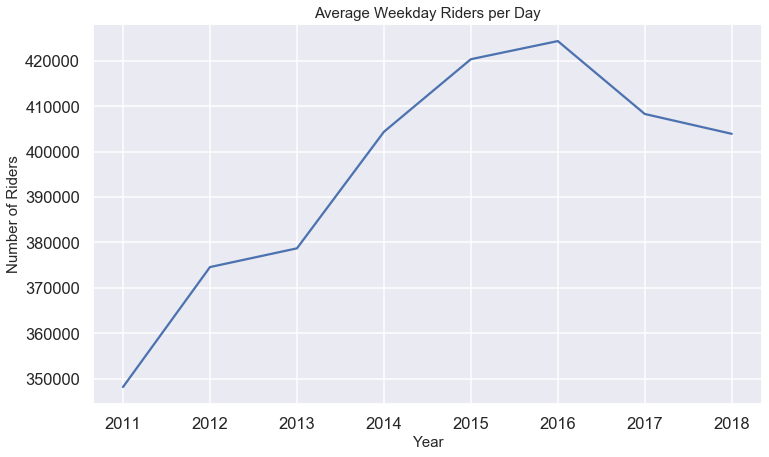

In [24]:
fig, axs = plt.subplots(figsize = (12, 7))
sns.lineplot(y = avg_weekday[0], x = avg_weekday.index, palette=("Blues"))
plt.title('Average Weekday Riders per Day', fontsize = 15)
plt.ylabel('Number of Riders', fontsize=15)
plt.xlabel("Year", fontsize=15)

In [25]:
weekday_11.head()

,date,month,day,hour,day_of_week,start,destination,throughput
38377,2011-01-03,1,3,0,0,12TH,24TH,1
38378,2011-01-03,1,3,0,0,12TH,ASHB,3
38379,2011-01-03,1,3,0,0,12TH,BAYF,1
38380,2011-01-03,1,3,0,0,12TH,CIVC,1
38381,2011-01-03,1,3,0,0,12TH,CONC,1


In [26]:
%%time
year = 2011
num_weekday = 260
morning_weekday = {}
afternoon_weekday = {}
off_prime_weekday = {}
off_peak_weekday = {}
for i in [weekday_11, weekday_12, weekday_13, weekday_14, weekday_15, weekday_16, weekday_17, weekday_18]:
    morning = i[(i['hour'] == 7) | (i['hour'] == 8) | (i['hour'] == 9)]
    afternoon = i[(i['hour'] == 16) | (i['hour'] == 17) | (i['hour'] == 18)]
    off_peak = i[(i['hour'] != 16)&(i['hour']!=17)&(i['hour']!=18)&(i['hour']!=7)&(i['hour']!=8)&(i['hour']!=9)]

    morning_weekday[year] = morning['throughput'].sum()/i['throughput'].sum()
    afternoon_weekday[year] = afternoon['throughput'].sum()/i['throughput'].sum()
    off_peak_weekday[year] = off_peak['throughput'].sum()/i['throughput'].sum()
    year += 1

Wall time: 22.2 s


In [27]:
morning_weekday = pd.DataFrame.from_dict(morning_weekday, orient = 'index')
afternoon_weekday = pd.DataFrame.from_dict(afternoon_weekday, orient = 'index')
off_peak_weekday = pd.DataFrame.from_dict(off_peak_weekday, orient = 'index')

In [28]:
off_peak_weekday

,0
2011,0.440086
2012,0.442414
2013,0.440554
2014,0.438560
2015,0.434112
2016,0.426213
2017,0.419448
2018,0.411107


Text(0.5, 0, 'Year')

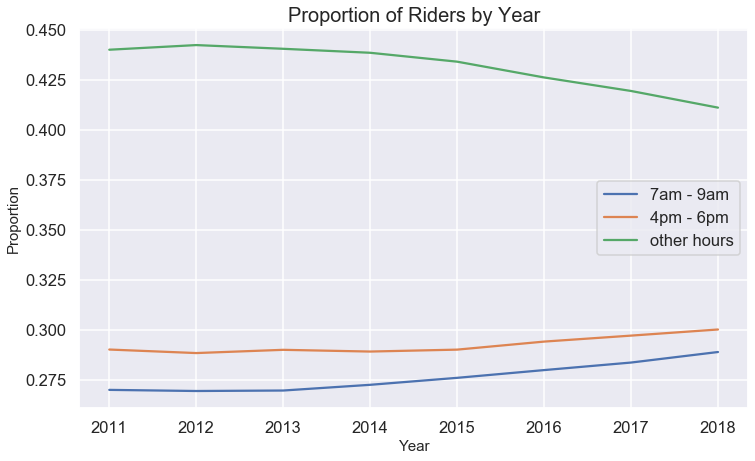

In [29]:
fig, axs = plt.subplots(figsize = (12, 7))
plt.title('Proportion of Riders by Year', fontsize = 20)
sns.lineplot(y = morning_weekday[0],x = morning_weekday.index, label = '7am - 9am')
sns.lineplot(y = afternoon_weekday[0],x = afternoon_weekday.index, label = '4pm - 6pm')
sns.lineplot(y = off_peak_weekday[0],x = off_peak_weekday.index, label = 'other hours')
plt.legend()
plt.ylabel('Proportion', fontsize=15)
plt.xlabel("Year", fontsize=15)

Text(0.5, 0, 'Time of Day')

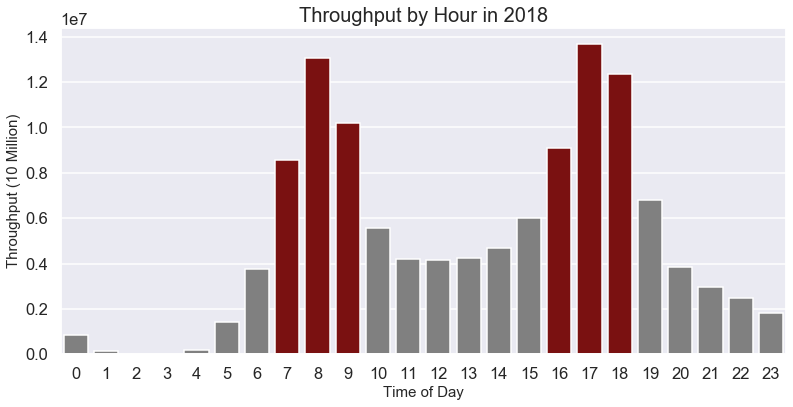

In [30]:
fig, axs = plt.subplots(figsize = (13, 6))
plt.title('Throughput by Hour in 2018', fontsize = 20)
clrs = ['gray' if (x not in [7, 8, 9, 16, 17, 18]) else 'darkred' for x in bart_18.groupby('hour').sum().index]
sns.barplot(y = bart_18.groupby('hour').sum()['throughput'], x = bart_18.groupby('hour').sum().index, palette=(clrs))

plt.ylabel('Throughput (10 Million)', fontsize=15)
plt.xlabel("Time of Day", fontsize=15)

In [31]:
# also use august bc it has no holidays, so the data is extremely consistent 
aug_17 = bart_17[bart_17['month'] == 8]
aug_18 = bart_18[bart_18['month'] == 8]

# only get the first 4 weeks of august to make sure each day of the week is represented exactly times
aug_17 = aug_17[aug_17['day'] <= 28]
aug_18 = aug_18[aug_18['day'] <= 28]

In [32]:
plots = bart_18.groupby('day_of_week').sum()

Text(0.5, 0, 'Day of the Week')

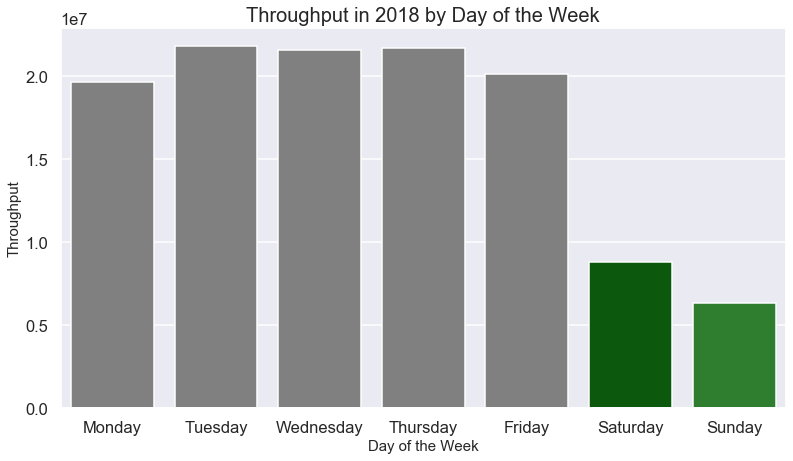

In [33]:
fig, axs = plt.subplots(figsize = (13, 7))
plt.title('Throughput in 2018 by Day of the Week', fontsize = 20)
clrs = ['gray' if (x not in [5, 6]) else 'darkgreen' if x == 5 else 'forestgreen' for x in plots.index]
sns.barplot(data = plots, x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], y='throughput', palette = clrs)
plt.ylabel('Throughput', fontsize=15)
plt.xlabel("Day of the Week", fontsize=15)

We can easily see that ridership falls off significantly on weekends! Ridership on Saturdays is not very different from Sunday at all.

In [34]:
aug_18.groupby('day_of_week').sum()[['throughput']].reset_index()

,day_of_week,throughput
0,0,1625602
1,1,1721174
2,2,1720498
3,3,1697772
4,4,1623642
5,5,639215
6,6,469205


## 2. Sunday vs Rest of the Week Permutation Testing

take only the trips that require a single train on sundays, and compare the amount of throughput. Do a permutation test accordingly. So itll look like:

no_transfer = only trips, of all days, that take no transfers to get to where you want. then segregate it by Weekdays, Saturday, Sunday;
- no_transfer_week
- no_transfer_sat
- no_transfer_sun
do a groupby on the day of the week.sum()

yes_transfer = all trips that do require a transfer (on sunday) then segregate it again
- transfer_week
- transfer_sat
- transfer_sun




In [ ]:
# Train stations that require no transfers, assuming the Start and Destination both belong to the same line
yellow_line = [
    'MLBR', 'SFIA', 'SBRN', 'SSAN', 'COLM', 'DALY','BALB', 'GLEN', '24TH', '16TH', 'CIVC','POWL', 'MONT', 'EMBR',\
    'ANTC', 'PCTR', 'PITT', 'NCON', 'CONC', 'ANTI','ORIN', 'LAFY', 'WCRK', 'PHIL',\
    'ROCK', 'MCAR', '19TH', '12TH'
]
orange_line = [
    'HAYW','SHAY','UCTY','FRMT', 'WARM', 'WSPR','RICH', 'DELN', 'PLZA','NBRK','DBRK','ASHB',\
    "MCAR", '12TH', '19TH','LAKE','FTVL','COLS', 'SANL','BAYF'
]
blue_line = [
    'CAST', 'WDUB', 'DUBL', "MCAR", '12TH', '19TH', 'LAKE','FTVL','COLS','SANL','BAYF'
]

In [ ]:
def get_no_transfers(df):
    """
    Takes df and adds a new column that indicates whether or not the trip requires a train transfer,
    assuming it runs on a Sunday train schedule
    """
    yellow = df[['start', 'destination']].isin(yellow_line) & df[['start', 'destination']].isin(yellow_line)
    yellow['yellow'] = yellow['start'] & yellow['destination']

    orange = df[['start', 'destination']].isin(orange_line) & df[['start', 'destination']].isin(orange_line)
    orange['orange'] = orange['start'] & orange['destination']

    blue = df[['start', 'destination']].isin(blue_line) & df[['start', 'destination']].isin(blue_line)
    blue['blue'] = blue['start'] & blue['destination']

    condition = pd.concat([yellow['yellow'], orange['orange'], blue['blue']], axis = 1)
    condition['no_transfer'] = condition['yellow'] | condition['orange'] | condition['blue']
    df['no_transfer'] = condition['no_transfer']
    return df

In [ ]:
aug_17 = get_no_transfers(aug_17)
aug_18 = get_no_transfers(aug_18)

In [ ]:
tr_18 = get_no_transfers(bart_18)

## More experimental Design
write a permutation test that showcases how the proportion of rides on sundays for transfers actually increases instead of decreases, alpha = 0.05.

This means that people seem to be undeterred by the fact that they have to transfer, otherwise we should be seeing a decrease in the number of rides that require a transfer. Transferring means that they have to physically change stations and denotes a longer commute time.

But we are able to show that the kinds of riders who ride on Saturday are similar to the kinds of people who ride on Sunday as opposed to the weekdays, then it can be another reason why changing Saturday schedules to sunday schedules are appropriate.

We can do this by showcasing the times in which people make their rides. since you had classified before hand the regions in which people ride from, then we can do a permutation test to see the number of rides that occur.

In [ ]:
t_18 = tr_18.copy()
t_18 = t_18[['day_of_week','start', 'destination', 'throughput', 'no_transfer']]

# Permutation Test on Transfers

### Observed Statistic

In [ ]:
no_transfer_18 = t_18[t_18['no_transfer'] == True].drop(columns = ['no_transfer'])
no_transfer_18 = no_transfer_18.groupby('day_of_week').sum()[['throughput']]
no_transfer_18['throughput'] = no_transfer_18['throughput']/no_transfer_18['throughput'].sum()
no_transfer_2018_sunday = no_transfer_18.iloc[6]['throughput']
no_transfer_2018_sunday
# interpretation: of all the rides that do not require a transfer on a sunday (and not on any other day), 
# Sunday accounts for 5.20% of them.

In [ ]:
transfer_18 = t_18[t_18['no_transfer'] == False].drop(columns = ['no_transfer'])
transfer_18 = transfer_18.groupby('day_of_week').sum()[['throughput']]
transfer_18['throughput'] = transfer_18['throughput']/transfer_18['throughput'].sum()
transfer_2018_sunday = transfer_18.iloc[6]['throughput']
transfer_2018_sunday
# interpretation: of all the rides that require a transfer on a sunday (and not on any other day), 
# Sunday accounts for 5.45% of them.

In [ ]:
# observed value:
no_transfer_2018_sunday - transfer_2018_sunday

In [ ]:
no_transfer_18.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [ ]:
no_transfer_18

In [ ]:
transfer_18.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [ ]:
transfer_18

### Calculate one test statistic

In [ ]:
def transfer_permutation_test(t_18):
    shuffle = t_18['no_transfer'].sample(replace = False, frac = 1).reset_index(drop = True)
    shuffled_original = t_18.assign(**{'no_transfer': shuffle})
    
    no_transfer_18 = shuffled_original[shuffled_original['no_transfer'] == True]#.drop(columns = ['no_transfer'])
    no_transfer_18 = no_transfer_18.groupby('day_of_week').sum()[['throughput']]
    no_transfer_18['throughput'] = no_transfer_18['throughput']/no_transfer_18['throughput'].sum()
    #print(no_transfer_18['throughput'])
    no_transfer_2018_sunday = no_transfer_18.iloc[6]['throughput']

    transfer_18 = shuffled_original[shuffled_original['no_transfer'] == False]#.drop(columns = ['no_transfer'])
    transfer_18 = transfer_18.groupby('day_of_week').sum()[['throughput']]
    transfer_18['throughput'] = transfer_18['throughput']/transfer_18['throughput'].sum()
    transfer_2018_sunday = transfer_18.iloc[6]['throughput']
    return no_transfer_2018_sunday - transfer_2018_sunday

In [ ]:
transfer_permutation_test(t_18)

### Avoid running this cell b/c 20 minute simulation time

In [ ]:
# %%time
# shuffle = []
# for i in range(500):
#     shuffle.append(transfer_permutation_test(t_18))

In [ ]:
fig, axs = plt.subplots(figsize = (7, 4))
plt.title('A/B Test on Transfer vs Non-Transfer Rides', fontsize = 20)
sns.distplot(shuffle, hist = True)
plt.axvline(-0.0024276234726327284, 0, 2, color = 'red')
plt.ylabel('Density', fontsize=15)
plt.xlabel("Difference Between Transfer & Non-Transfer", fontsize=15)

In [ ]:
np.count_nonzero(shuffle > no_transfer_2018_sunday - transfer_2018_sunday)

## Difference in Region A/B Test

In [ ]:
bart_region = bart_18.copy()
bart_region = bart_region[['day_of_week', 'start', 'throughput']]
bart_region.head()

In [ ]:
sun_18 = bart_region[bart_region['day_of_week'] == 6].groupby('start').sum()[['throughput']]
sat_18 = bart_region[bart_region['day_of_week'] == 5].groupby('start').sum()[['throughput']]
weekday_18 = bart_region[(bart_region['day_of_week'] != 5) & (bart_region['day_of_week'] != 6)].groupby('start').sum()[['throughput']]
district_lst = []

for i in sun_18.iterrows():
    district_lst.append(bart_district[i[0]])
sun_18['district'] = district_lst
sat_18['district'] = district_lst
weekday_18['district'] = district_lst
    
sat_18 = sat_18.reset_index().groupby('district').sum()[['throughput']]
sat_18['throughput'] = sat_18['throughput']/sat_18['throughput'].sum()

sun_18 = sun_18.reset_index().groupby('district').sum()[['throughput']]
sun_18['throughput'] = sun_18['throughput']/sun_18['throughput'].sum()

weekday_18 = weekday_18.reset_index().groupby('district').sum()[['throughput']]
weekday_18['throughput'] = weekday_18['throughput']/weekday_18['throughput'].sum()
sun_sat = (abs(sun_18 - sat_18)).sum()
sun_weekday = (abs(sun_18 - weekday_18)).sum()

### Variance Analysis 

In [ ]:
bart_one = bart_18[(bart_18['day_of_week'] != 5) & (bart_18['day_of_week'] != 6)]

weekday_count = len(np.unique(bart_one['date']))
test_plot_one = bart_one.groupby('hour').sum()[['throughput']]
sns.barplot(y = test_plot_one['throughput']/weekday_count, x = test_plot_one.index, palette = 'blues')

In [ ]:
bart_one.groupby('hour').std()[['throughput']]

In [ ]:
bart_test = bart_18[(bart_18['day_of_week'] == 5) | (bart_18['day_of_week'] == 6)]
test_plot = bart_test.groupby('hour').sum()[['throughput']]
weekend_count = len(np.unique(bart_test['date']))

fig, axs = plt.subplots(figsize = (2, 2))
plt.title('Weekend Traffic by Hour in 2018', fontsize = 20)
sns.lineplot(y = test_plot['throughput']/weekend_count, x = test_plot.index, label = 'Weekend', ci = 'sd', n_boot = 100, err_style = 'band')
sns.lineplot(y = test_plot_one['throughput']/weekday_count, x = test_plot_one.index, label = 'Weekday', ci = 'sd', n_boot = 100)

plt.legend()
plt.ylabel('Average Throughput by Day', fontsize=15)
plt.xlabel("Time of Day", fontsize=15)

In [ ]:
bart_test[bart_test['hour'] == 10].groupby('date').sum()['throughput'].std()

In [ ]:
# Weekends
std_dict = {}
for i in range(24):
    std_dict[i] = bart_test[bart_test['hour'] == i].groupby('date').sum()['throughput'].std()

In [ ]:
std_dict

In [ ]:
# Weekdays
std_dict_weekday = {}
for i in range(24):
    std_dict_weekday[i] = bart_one[bart_one['hour'] == i].groupby('date').sum()['throughput'].std()

In [ ]:
std_df = pd.DataFrame.from_dict(std_dict_weekday, orient = 'index')
std_df['weekend'] = std_dict.values()
std_df['weekday'] = std_dict_weekday.values()
std_df = std_df.drop(columns = [0])
std_df

fig, axs = plt.subplots(figsize = (12, 6))

plt.title('Weekend Traffic Standard Deviation, by Hour in 2018')
sns.lineplot(y = std_df['weekend'], x = std_df.index, label = 'Weekend')
sns.lineplot(y = std_df['weekday'], x = std_df.index, label = 'Weekday')
plt.ylabel('Standard Deviation', fontsize=15)
plt.xlabel("Time of Day", fontsize=15)

In [ ]:
def sunday_difference_null_hypothesis(bart_region):
    shuffle = bart_region['day_of_week'].sample(replace = False, frac = 1).reset_index(drop = True)
    bart_region = bart_region.assign(**{'day_of_week': shuffle})
    sun_18 = bart_region[bart_region['day_of_week'] == 6].groupby('start').sum()[['throughput']]
    sat_18 = bart_region[bart_region['day_of_week'] == 5].groupby('start').sum()[['throughput']]
    weekday_18 = bart_region[(bart_region['day_of_week'] != 5) & (bart_region['day_of_week'] != 6)].groupby('start').sum()[['throughput']]
    district_lst = []

    for i in sun_18.iterrows():
        district_lst.append(bart_district[i[0]])
    sun_18['district'] = district_lst
    sat_18['district'] = district_lst
    weekday_18['district'] = district_lst
    
    sat_18 = sat_18.reset_index().groupby('district').sum()[['throughput']]
    sat_18['throughput'] = sat_18['throughput']/sat_18['throughput'].sum()

    sun_18 = sun_18.reset_index().groupby('district').sum()[['throughput']]
    sun_18['throughput'] = sun_18['throughput']/sun_18['throughput'].sum()

    weekday_18 = weekday_18.reset_index().groupby('district').sum()[['throughput']]
    weekday_18['throughput'] = weekday_18['throughput']/weekday_18['throughput'].sum()
    sun_sat = (abs(sun_18 - sat_18)).sum()
    sun_weekday = (abs(sun_18 - weekday_18)).sum()
    return sun_sat - sun_weekday

In [ ]:
sunday_difference_null_hypothesis(bart_region)

### Don't run this bc it takes 24 minutes

In [ ]:
# %%time
# sunday_hypo = []
# for i in range(500):
#     sunday_hypo.append(sunday_difference_null_hypothesis(bart_region))

In [ ]:
fig, axs = plt.subplots(figsize = (14, 7))
plt.title('A/B Test on Sun/Sat vs Sun/Weekday', fontsize = 20)
sns.distplot(sunday_hypo, hist = True)
plt.axvline(0.041435, 0, 2, color = 'red')
plt.ylabel('Density', fontsize=15)
plt.xlabel("Difference Between Sun/Sat vs Sun/Weekday", fontsize=15)

In [ ]:
weekends = sun_18 - sat_18
weekends

In [ ]:
weekend_weekday = sun_18 - weekday_18
weekend_weekday

In [ ]:
sun_sat = (abs(sun_18 - sat_18)).sum()

In [ ]:
sun_weekday = (abs(sun_18 - weekday_18)).sum()

In [ ]:
sun_sat

In [ ]:
sun_weekday

In [ ]:
fig, axs = plt.subplots(figsize = (12, 7))
plt.title('Difference in Start Point b/t Sunday and Saturday', fontsize = 20)
sns.barplot(y = weekends.index, x = weekends['throughput'])
plt.ylabel('District', fontsize=15)
plt.xlabel("Difference in Throughput Proportion", fontsize=15)

In [ ]:
fig, axs = plt.subplots(figsize = (12, 7))
plt.title('Difference in Start Point b/t Sunday and Weekdays', fontsize = 20)
sns.barplot(y = weekend_weekday.index, x = weekend_weekday['throughput'])
plt.ylabel('District', fontsize=15)
plt.xlabel("Difference in Throughput Proportion", fontsize=15)

In [ ]:
morn_dest = jan_2018_morn.groupby('destination').sum()[['throughput']]

district_lst = []
for i in morn_dest.iterrows():
     district_lst.append(bart_district[i[0]])

morn_dest['district'] = district_lst
morn_dest;

In [ ]:
morn = morn_start.sort_values('throughput', ascending = False)
dest = morn_dest.sort_values('throughput', ascending = False) 

In [ ]:
fig, axs = plt.subplots(figsize = (15, 3))
sns.barplot(y = morn.index[:10], x = morn['throughput'][:10], hue = morn['district'][:10], dodge = False)
plt.title('Top Ten Stations Traffic Between 7am-10am [LEAVING]', fontsize = 20)

In [ ]:
fig, axs = plt.subplots(figsize = (15,3))
sns.barplot(y = dest.index[:10], x = dest['throughput'][:10], hue = dest['district'][:10], dodge = False)

In [ ]:
dest['throughput'][:10], dest.index[:10]

In [ ]:
# plt.ylabel('Conversion Rate', fontname="Arial", fontsize=15)
# plt.xlabel("Date", fontsize=15)
# plt.legend(prop = {'size': 14})
# plt.title('Conversion Rate by Day', fontsize = 20)

In [ ]:
# # will convert all of the destinations into its respective name
# station_dict = {}
# for i in station.iterrows():
#     station_dict[i[1]['Abbreviation']] = i[1]['Name'][:-7]

# station_func = np.vectorize(lambda x: station_dict[x])
# bart['start'] = station_func(np.array(bart['start']))
# bart['destination'] = station_func(np.array(bart['destination']))